# Evaluation Of Duet Benchmarking Results from Distributed Database "Cassandra"

### Imports

In [326]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
from pathlib import Path

### Import Benchmarking Measurements as csv file and create Pandas Dataframe for further Analysis

In [327]:
cwd = Path.cwd()
print(cwd)
filepath = os.path.join(cwd, "Results", "10_000ops", "load_measurements.csv")
print(filepath)
df = pd.read_csv(filepath)

C:\Users\Felix Medicus\Desktop\Thesis_MCC\DuetBenchmarking\Results
C:\Users\Felix Medicus\Desktop\Thesis_MCC\DuetBenchmarking\Results\Results\10_000ops\load_measurements.csv


### Insert latencies in ms into the measurement table

In [328]:
df["latency_ms"] = df["received"]- df["sent"]

### Create subsets of dataframe (for Version A and B, and for each worker for Version A and B) 

In [329]:
dfA1 = df.loc[(df["workerId"] == "w1a")]
dfA2 = df.loc[(df["workerId"] == "w2a")]
dfA3 = df.loc[(df["workerId"] == "w3a")]
dfB1 = df.loc[(df["workerId"] == "w1b")]
dfB2 = df.loc[(df["workerId"] == "w2b")]
dfB3 = df.loc[(df["workerId"] == "w3b")]
dfA = df.loc[(df["workerId"] == "w1a") | (df["workerId"] == "w2a") | (df["workerId"] == "w3a")]
dfB = df.loc[(df["workerId"] == "w1b") | (df["workerId"] == "w2b") | (df["workerId"] == "w3b")]

### Return experiment run time (First request send to last response received)

In [330]:
totalTime = df["received"].max() - df["sent"].min()
print(totalTime/1000/60, "minuten")

2.6450833333333335 minuten


### Min. Latencies for Worker 2 (A & B)

In [331]:
dfA2.loc[dfA2["latency_ms"].idxmin()]

workerId                                          w2a
queryType                                      INSERT
queryId          d1c1d7fb-fec8-4194-b5b0-8e5cafab17f3
sent                                    1657808651069
received                                1657808651072
target-region                            europe-west1
latency_ms                                          3
Name: 12426, dtype: object

In [332]:
dfB2.loc[dfB2["latency_ms"].idxmin()]

workerId                                          w2b
queryType                                      INSERT
queryId          359f02b6-4335-4bf9-992b-c0eb15c764c7
sent                                    1657808644390
received                                1657808644393
target-region                            europe-west1
latency_ms                                          3
Name: 12128, dtype: object

### Some checks

#### Time difference in ms when first query was sent by worker-1 to Version A and B 

In [338]:

dfA2["sent"].min() - dfB2["sent"].min()

-4

#### Time difference in ms when last query was sent by worker-1 to Version A and B 

In [339]:
dfA1["sent"].max() - dfB1["sent"].max() 


343

## Create Figures 

### Create Boxplots

In [340]:
sns.set_theme(style="darkgrid")

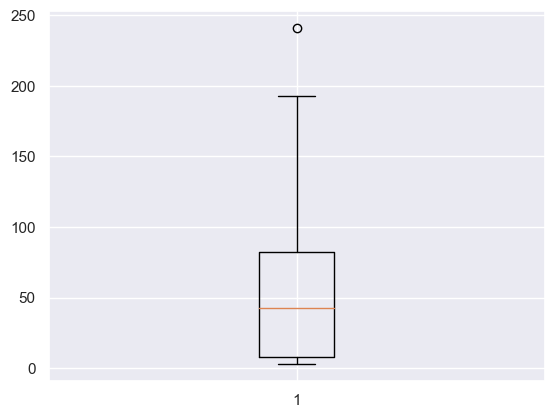

In [341]:
ax = plt.boxplot(x=dfA["latency_ms"])


### Create Flowchart

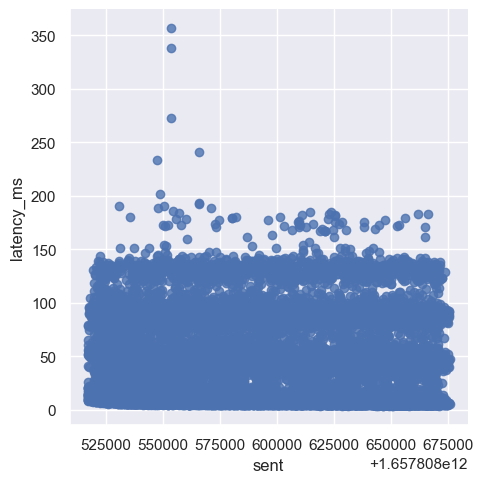

In [342]:
sns.lmplot(x='sent', y='latency_ms', data=df, fit_reg=False)